# 데이터 로드 및 전처리

In [367]:
import yfinance as yf

# 삼성전자 종목코드: 005930
df = yf.download('005930.KS', start = '2018-01-01', end = '2021-01-01')
df.head()

[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2018-01-02,51380.0,51400.0,50780.0,51020.0,43093.250000,8474250
2018-01-03,52540.0,52560.0,51420.0,51620.0,43600.035156,10013500
2018-01-04,52120.0,52180.0,50640.0,51080.0,43143.921875,11695450
2018-01-05,51300.0,52120.0,51200.0,52120.0,44022.347656,9481150
2018-01-08,52400.0,52520.0,51500.0,52020.0,43937.886719,8383650


In [368]:
df = df[['Open', 'High', 'Low', 'Close', 'Volume']]
df.head()

,Open,High,Low,Close,Volume
Date,,,,,
2018-01-02,51380.0,51400.0,50780.0,51020.0,8474250
2018-01-03,52540.0,52560.0,51420.0,51620.0,10013500
2018-01-04,52120.0,52180.0,50640.0,51080.0,11695450
2018-01-05,51300.0,52120.0,51200.0,52120.0,9481150
2018-01-08,52400.0,52520.0,51500.0,52020.0,8383650


In [369]:
# 스케일링
from sklearn.preprocessing import RobustScaler

x_rs = RobustScaler()
X_Scaled = x_rs.fit_transform(df[['Open','High','Low','Volume']])

y_rs = RobustScaler()
y = y_rs.fit_transform(df[['Close']])

# GPU 학습 준비

In [370]:
# gpu 학습
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
device = torch.device("cuda:0" if torch.cuda.is_available() else 'cpu')

# 학습 가능한 시퀀스 형태로 데이터 변환

In [371]:
# 데이터를 모델이 학습 가능한 시퀀스 형태로 만들기
sequence_length = 10
x_seq = []
y_seq = []

for i in range(len(X_Scaled) - sequence_length):
  x_seq.append(X_Scaled[i:i+sequence_length]) # 0 ~ 4
  y_seq.append(y[i+sequence_length]) # i가 0일 때, 시퀀스 길이 5를 더해서 5가 되니까 6일 때 Close

# torch에서 학습 가능한 형태로 바꾸기
x_seq = torch.FloatTensor(x_seq).to(device)

# (n, 1) 즉, 열벡터의 정답값 만들기
y_seq = torch.FloatTensor(y_seq).to(device).view(-1, 1)

In [372]:
# 데이터셋의 80%에 해당하는 갯수 계산하기
print(int(x_seq.shape[0] * 0.8))

582


# 미니배치셋으로 생성

In [373]:
# 3차원 shape이라서 직접 slicing해서 train valid 데이터셋으로 만들기
x_train = x_seq[:int(x_seq.shape[0] * 0.8)] # 80%까지
x_valid = x_seq[int(x_seq.shape[0] * 0.8):] # 80%부터 끝까지 => 20%

y_train = y_seq[:int(x_seq.shape[0] * 0.8)] # 80%까지
y_valid = y_seq[int(x_seq.shape[0] * 0.8):] # 80%부터 끝까지 => 20%

In [374]:
print(x_train.size(), y_train.size())
print(x_valid.size(), y_valid.size())

torch.Size([582, 10, 4]) torch.Size([582, 1])
torch.Size([146, 10, 4]) torch.Size([146, 1])


In [375]:
# 미니배치셋으로 생성하기
train = torch.utils.data.TensorDataset(x_train, y_train)
valid = torch.utils.data.TensorDataset(x_valid, y_valid)

train_loader = torch.utils.data.DataLoader(train, batch_size = 30, shuffle = True)
valid_loader = torch.utils.data.DataLoader(valid, batch_size = 30, shuffle = False)

In [376]:
# RNN을 위한 사이즈 하이퍼 파라미터
# 피처가 4개이므로 입력사이즈는 4
input_size = x_seq.size(2)
print(input_size)

# 1시퀀스당 hidden 레이어 갯수
num_layers = 2

# 시퀀스 유닛(= 모델의 히든 시퀀스 길이) 갯수
hidden_size = 20

4


# 모델 학습

### 1) RNN

In [377]:
class RNN(nn.Module):
  def __init__(self, input_size, hidden_size, sequence_length, num_layers, device):
    super(RNN, self).__init__()
    self.device = device
    self.hidden_size = hidden_size
    self.num_layers = num_layers
    self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True).to(self.device)
    self.fc =  nn.Sequential(
                             nn.Linear(hidden_size * sequence_length, 1 ),
                             nn.ReLU()
                             )
  def forward(self, x):
    h0 = torch.zeros(self.num_layers, x.size()[0], self.hidden_size).to(self.device)

    out,_ = self.rnn(x, h0)
    out = out.reshape(out.shape[0], -1)
    out = self.fc(out)
    return out

In [378]:
model = RNN(input_size, hidden_size, sequence_length, num_layers, device).to(device)

In [379]:
criterion = nn.MSELoss()
num_epochs = 300
optimizer = optim.Adam(model.parameters(), lr = 0.001)

In [380]:
loss_log = []

for epoch in range(num_epochs):
  running_loss = 0
  for data in train_loader:
    seq, target = data
    outputs = model(seq)
    optimizer.zero_grad()

    loss = criterion(outputs, target)
    loss.backward()
    optimizer.step()
    running_loss += loss.item()
  loss_log.append(running_loss)
  if epoch % 10 == 0:
    print(f'[epoch : {epoch}] loss : {running_loss/len(train_loader)}')

[epoch : 0] loss : 0.2742943733930588
[epoch : 10] loss : 0.2092969235032797
[epoch : 20] loss : 0.20079299435019493
[epoch : 30] loss : 0.20196369029581546
[epoch : 40] loss : 0.20227723829448224
[epoch : 50] loss : 0.20127171874046326
[epoch : 60] loss : 0.1998229831457138
[epoch : 70] loss : 0.2004402231425047
[epoch : 80] loss : 0.19565348252654075
[epoch : 90] loss : 0.20538103766739368
[epoch : 100] loss : 0.19851655103266239
[epoch : 110] loss : 0.19940312393009663
[epoch : 120] loss : 0.19854268617928028
[epoch : 130] loss : 0.20029914416372777
[epoch : 140] loss : 0.19584023766219616
[epoch : 150] loss : 0.19492017477750778
[epoch : 160] loss : 0.20211318098008632
[epoch : 170] loss : 0.2033175364136696
[epoch : 180] loss : 0.19518198259174824
[epoch : 190] loss : 0.19626459553837777
[epoch : 200] loss : 0.19587750919163227
[epoch : 210] loss : 0.1992892473936081
[epoch : 220] loss : 0.19940886460244656
[epoch : 230] loss : 0.19944455586373805
[epoch : 240] loss : 0.1944138903

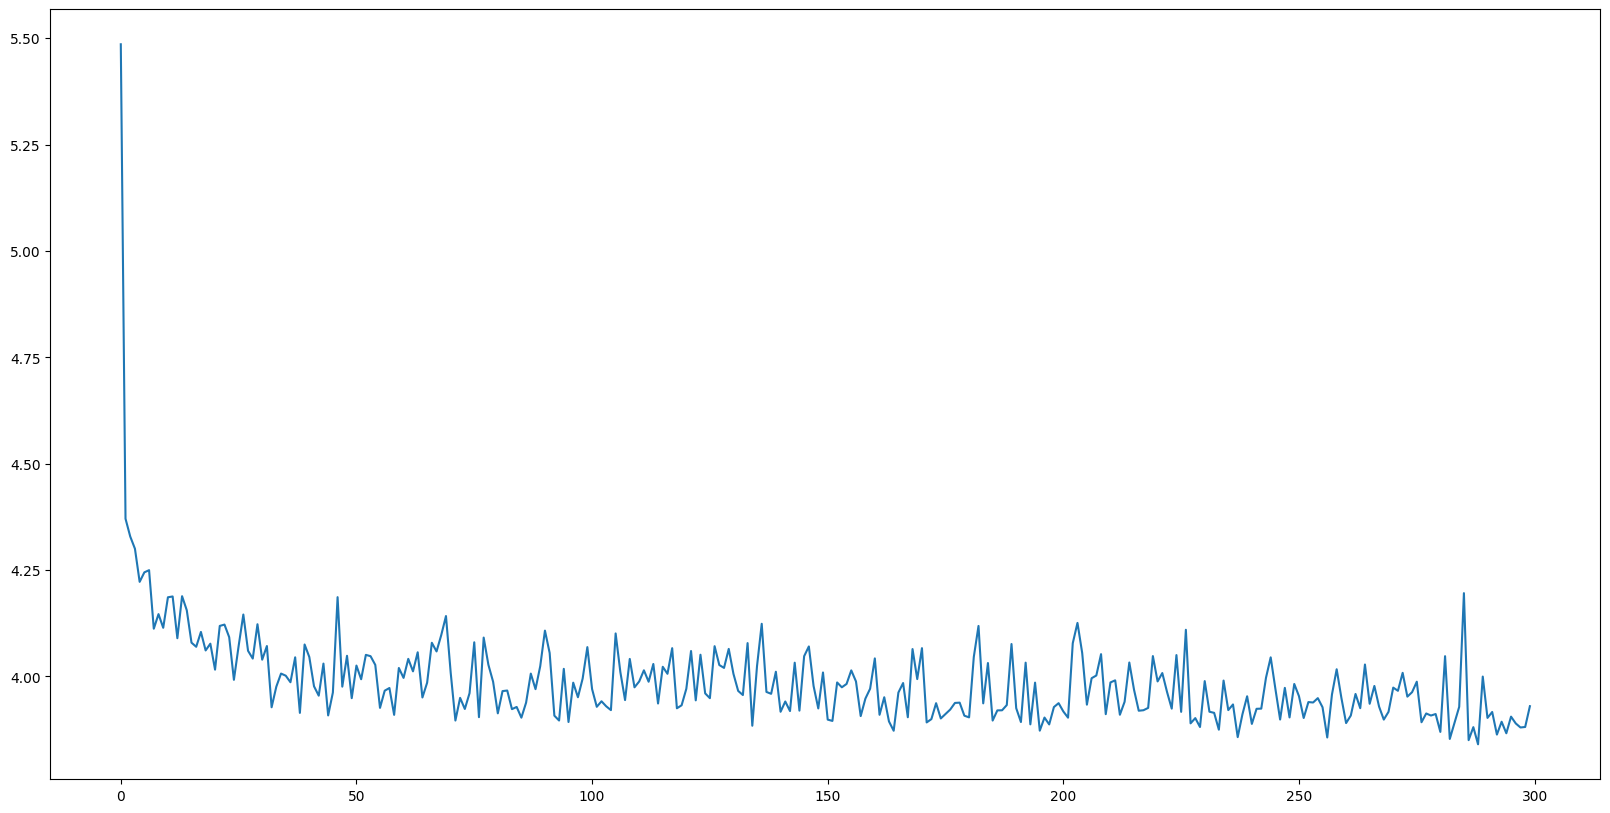

In [381]:
plt.figure(figsize = (20, 10))
plt.plot(loss_log)
plt.show()

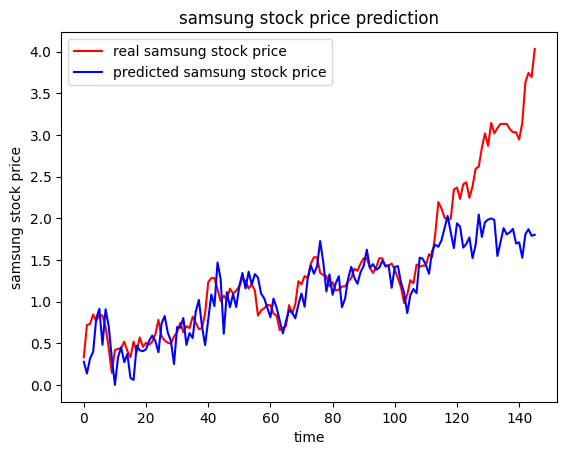

samsung 주가 : tensor([1.8021], grad_fn=<DivBackward0>) KRW


In [382]:
# 실제값 vs 예측값
pred_y = model(x_valid)

plt.figure()
plt.plot(y_valid, color='red', label='real samsung stock price')
plt.plot(pred_y.detach().numpy(), color='blue', label='predicted samsung stock price')
plt.title('samsung stock price prediction')
plt.xlabel('time')
plt.ylabel('samsung stock price')
plt.legend()
plt.show()

print("samsung 주가 :", df.Close[-1] * pred_y[-1] / df.Close[-1], 'KRW')

### 2) LSTM

In [383]:
class LSTM(nn.Module):
  def __init__(self, input_size, hidden_size, sequence_length, num_layers, device):
    super(LSTM, self).__init__()
    self.device = device
    self.hidden_size = hidden_size
    self.num_layers = num_layers
    self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first = True)
    self.fc = nn.Linear(hidden_size*sequence_length ,1)

  def forward(self, x):
    h0 = torch.zeros(self.num_layers, x.size()[0], self.hidden_size).to(self.device)
    c0 = torch.zeros(self.num_layers, x.size()[0], self.hidden_size).to(self.device)
    out, _ = self.lstm(x,(h0,c0))
    out = out.reshape(out.shape[0], -1)
    out = self.fc(out)
    return out

In [384]:
model = LSTM(input_size, hidden_size, sequence_length, num_layers, device).to(device)
criterion = nn.MSELoss()
num_epochs = 300
optimizer = optim.Adam(model.parameters(), lr = 0.001)

In [385]:
loss_log = []
for epoch in range(num_epochs):
  running_loss = 0
  for data in train_loader:
    seq, target = data
    outputs = model(seq)
    optimizer.zero_grad()

    loss = criterion(outputs, target)
    loss.backward()
    optimizer.step()
    running_loss += loss.item()
  loss_log.append(running_loss)
  if epoch % 10 == 0:
    print(f'[epoch : {epoch}] loss: {running_loss/len(train_loader)}')

[epoch : 0] loss: 0.29957881569862366
[epoch : 10] loss: 0.03916803225874901
[epoch : 20] loss: 0.028274850500747562
[epoch : 30] loss: 0.01906374366953969
[epoch : 40] loss: 0.014925410598516464
[epoch : 50] loss: 0.01289331924635917
[epoch : 60] loss: 0.011775172827765346
[epoch : 70] loss: 0.010926316655240954
[epoch : 80] loss: 0.010826491541229189
[epoch : 90] loss: 0.01114139067940414
[epoch : 100] loss: 0.010693871672265232
[epoch : 110] loss: 0.01072139134630561
[epoch : 120] loss: 0.009573384770192206
[epoch : 130] loss: 0.009529728046618401
[epoch : 140] loss: 0.009172157873399556
[epoch : 150] loss: 0.009271419211290776
[epoch : 160] loss: 0.009110078681260347
[epoch : 170] loss: 0.00912798116914928
[epoch : 180] loss: 0.008761965204030275
[epoch : 190] loss: 0.009091623988933862
[epoch : 200] loss: 0.008776265825144947
[epoch : 210] loss: 0.008506979001685977
[epoch : 220] loss: 0.008280041883699596
[epoch : 230] loss: 0.008178537990897895
[epoch : 240] loss: 0.007929191377

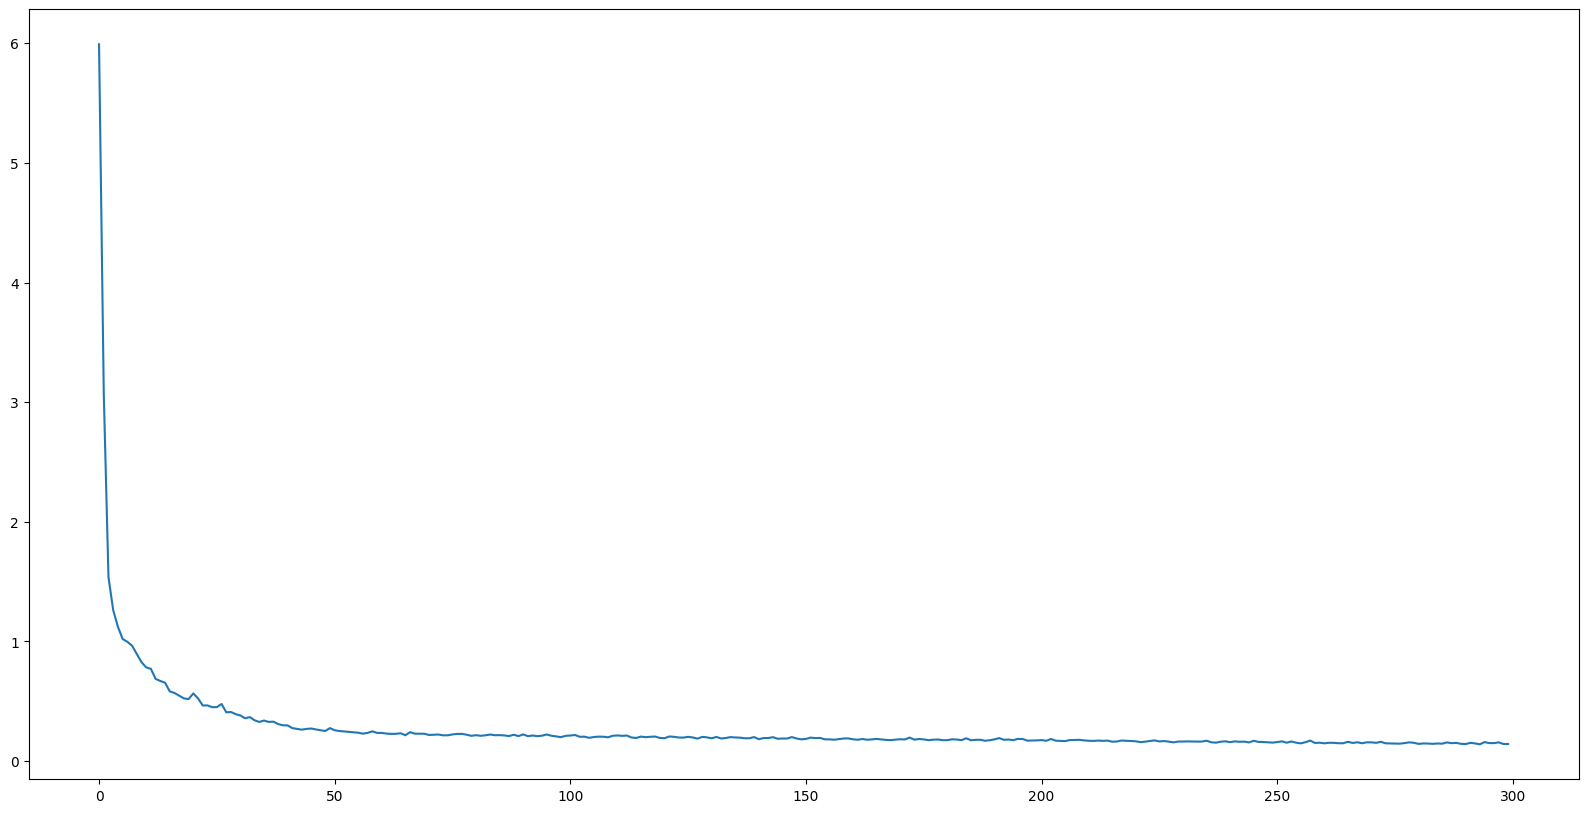

In [386]:
plt.figure(figsize = (20, 10))
plt.plot(loss_log)
plt.show()

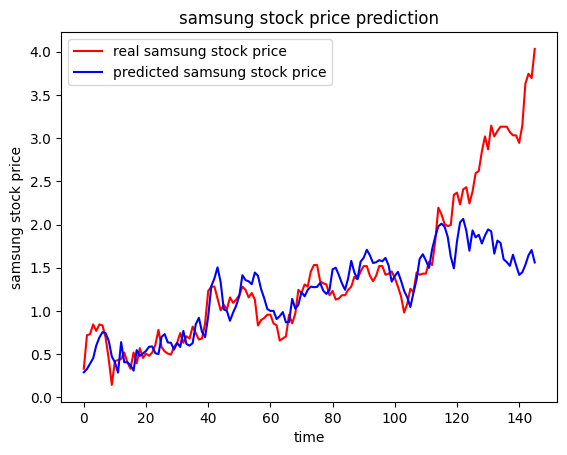

samung 주가 : tensor([1.5614], grad_fn=<DivBackward0>) KRW


In [387]:
# 실제값 vs 예측값
pred_y = model(x_valid)

plt.figure()
plt.plot(y_valid, color = 'red', label = 'real samsung stock price')
plt.plot(pred_y.detach().numpy(), color = 'blue', label = 'predicted samsung stock price')
plt.title('samsung stock price prediction')
plt.xlabel('time')
plt.ylabel('samsung stock price')
plt.legend()
plt.show()

print("samung 주가 :", df.Close[-1] * pred_y[-1] / df.Close[-1], 'KRW')

### 3) GRU

In [388]:
class GRU(nn.Module):
    def __init__(self, input_size, hidden_size, sequence_length, num_layers, device):
        super(GRU, self).__init__()
        self.device = device
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.gru = nn.GRU(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size * sequence_length, 1)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(self.device)
        out, _ = self.gru(x, h0)
        out = out.reshape(out.size(0), -1)
        out = self.fc(out)
        return out

In [389]:
model = GRU(input_size, hidden_size, sequence_length, num_layers, device).to(device)

In [390]:
criterion = nn.MSELoss()
num_epochs = 300
optimizer = optim.Adam(model.parameters(), lr = 0.001)

In [391]:
loss_log_gru = []
for epoch in range(num_epochs):
    running_loss = 0
    for data in train_loader:
        seq, target = data
        outputs = model(seq)
        optimizer.zero_grad()
        loss = criterion(outputs, target)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    loss_log_gru.append(running_loss)
    if epoch % 10 == 0:
        print(f'[epoch : {epoch}] loss: {running_loss/len(train_loader)}')

[epoch : 0] loss: 0.26377555839717387
[epoch : 10] loss: 0.02621934013441205
[epoch : 20] loss: 0.01866697808727622
[epoch : 30] loss: 0.014646008727140725
[epoch : 40] loss: 0.01309977238997817
[epoch : 50] loss: 0.012310115201398731
[epoch : 60] loss: 0.011679482855834067
[epoch : 70] loss: 0.0115786696318537
[epoch : 80] loss: 0.010698824725113808
[epoch : 90] loss: 0.010298130684532225
[epoch : 100] loss: 0.010359359090216458
[epoch : 110] loss: 0.010206724959425628
[epoch : 120] loss: 0.00954789889510721
[epoch : 130] loss: 0.009430184471420943
[epoch : 140] loss: 0.009004293009638786
[epoch : 150] loss: 0.009102594782598316
[epoch : 160] loss: 0.00915059745311737
[epoch : 170] loss: 0.009375676745548844
[epoch : 180] loss: 0.008404177520424128
[epoch : 190] loss: 0.00779905057279393
[epoch : 200] loss: 0.0077043511671945454
[epoch : 210] loss: 0.007968351920135319
[epoch : 220] loss: 0.007484377000946551
[epoch : 230] loss: 0.007383116078563035
[epoch : 240] loss: 0.0069705549161

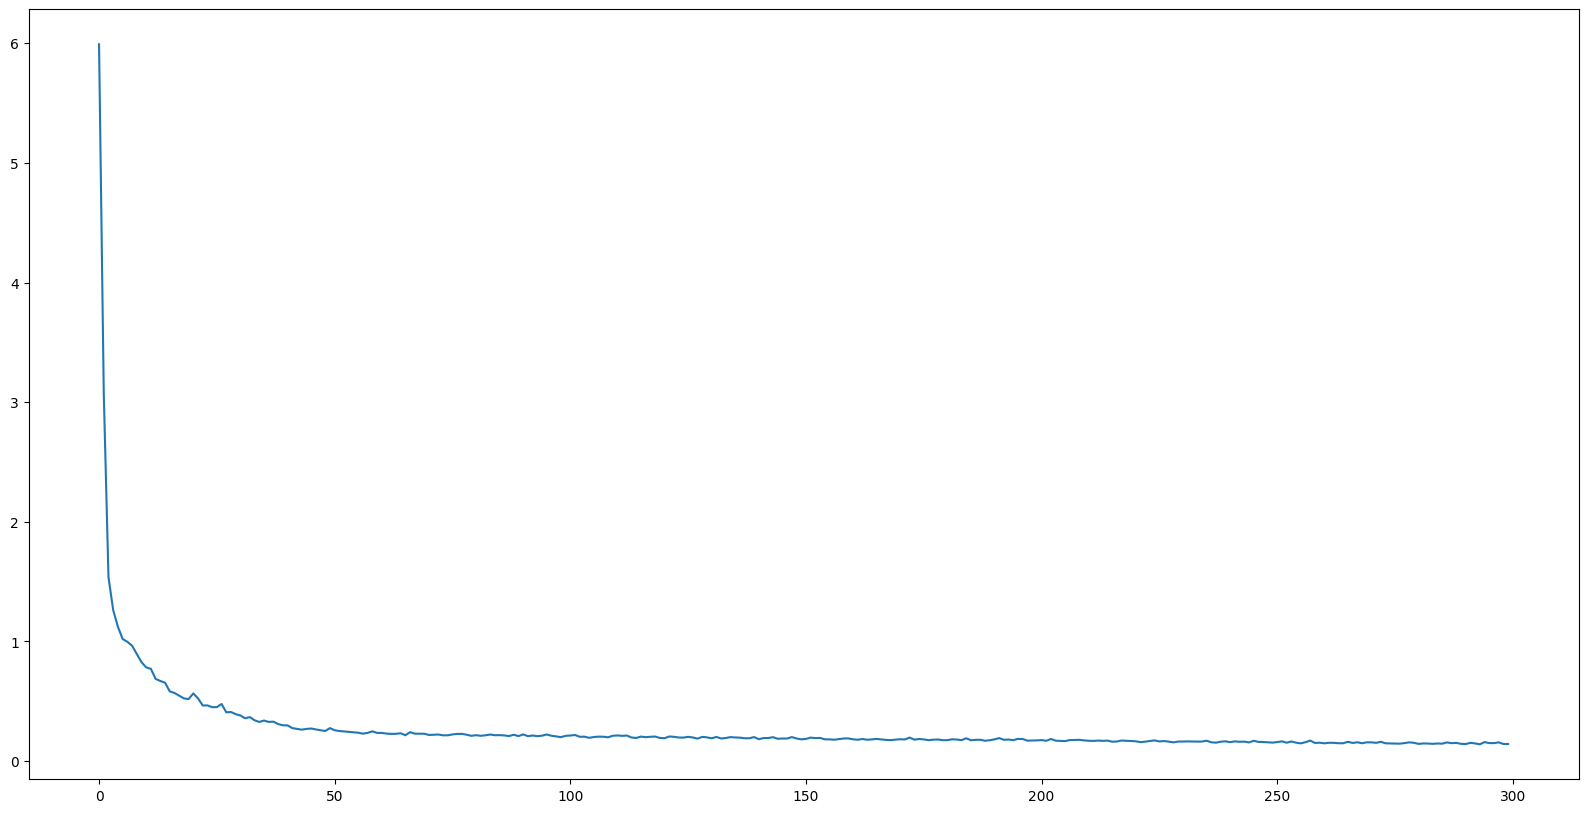

In [392]:
plt.figure(figsize=(20,10))
plt.plot(loss_log)
plt.show()

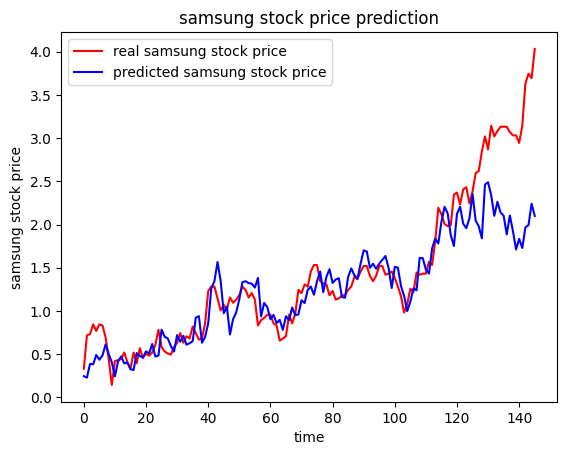

samsung 주가 : tensor([2.0998], grad_fn=<DivBackward0>) KRW


In [393]:
# 실제값 vs 예측값
pred_y = model(x_valid)

plt.figure()
plt.plot(y_valid, color='red', label='real samsung stock price')
plt.plot(pred_y.detach().numpy(), color='blue', label='predicted samsung stock price')
plt.title('samsung stock price prediction')
plt.xlabel('time')
plt.ylabel('samsung stock price')
plt.legend()
plt.show()

print("samsung 주가 :", df.Close[-1] * pred_y[-1] / df.Close[-1], 'KRW')